In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# #Make GP and Simulator class
# #Define Simulator Class (Export your Simulator Object Here)
# cs_name_val = 10
# noise_mean = 0
# noise_std = None
# seed = 1
# gen_meth_x = 2
# gen_meth_theta = 1
# num_x_data = 5
# ep_enum_val = 1
# ep0 = 1
# sep_fact = 1.0
# num_theta_multiplier = 10
# meth_name_val = 3
# meth_name = Method_name_enum(meth_name_val)
# method = GPBO_Methods(meth_name)
# ep_enum = Ep_enum(ep_enum_val)
# simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
# gen_meth_x = Gen_meth_enum(gen_meth_x)
# exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, seed)
# ep_bias = Exploration_Bias(ep0, None, ep_enum, None, None, None, None, None, None, None)
# num_theta_data = len(simulator.indeces_to_consider)*num_theta_multiplier
# gen_meth_theta = Gen_meth_enum(gen_meth_theta)
# #Note at present, training data is always the same between jobs since we set the data generation seed to 1
# sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, sep_fact, seed, False)
# #Gen sse_sim_data and sse_sim_val_data
# sim_sse_data = simulator.sim_data_to_sse_sim_data(method, sim_data, exp_data, sep_fact, False)

results = open_file_helper("workspace/5e0b42581b9f714806b17a017ab9e9b6/BO_Results.gz")

In [3]:
gp_object = copy.copy(results[0].list_gp_emulator_class[12])
simulator = copy.copy(results[0].simulator_class)

In [4]:
#Update scaler to be the fitted scaler. This scaler will change as the training data is updated
gp_object.scalerX = gp_object.scalerX.fit(gp_object.feature_train_data)
gp_object.scalerY = gp_object.scalerY.fit(gp_object.train_data.y_vals.reshape(-1,1))
#Scale training data if necessary
feature_train_data_scaled = gp_object.scalerX.transform(gp_object.feature_train_data)
y_train_data_scaled = gp_object.scalerY.transform(gp_object.train_data.y_vals.reshape(-1,1))
y = y_train_data_scaled

2.7504880093939362e-17 1.0


Text(0.5, 1.0, 'Histogram of ln(V(Ax0y0) - V_min(Ax0y0) + jitter)')

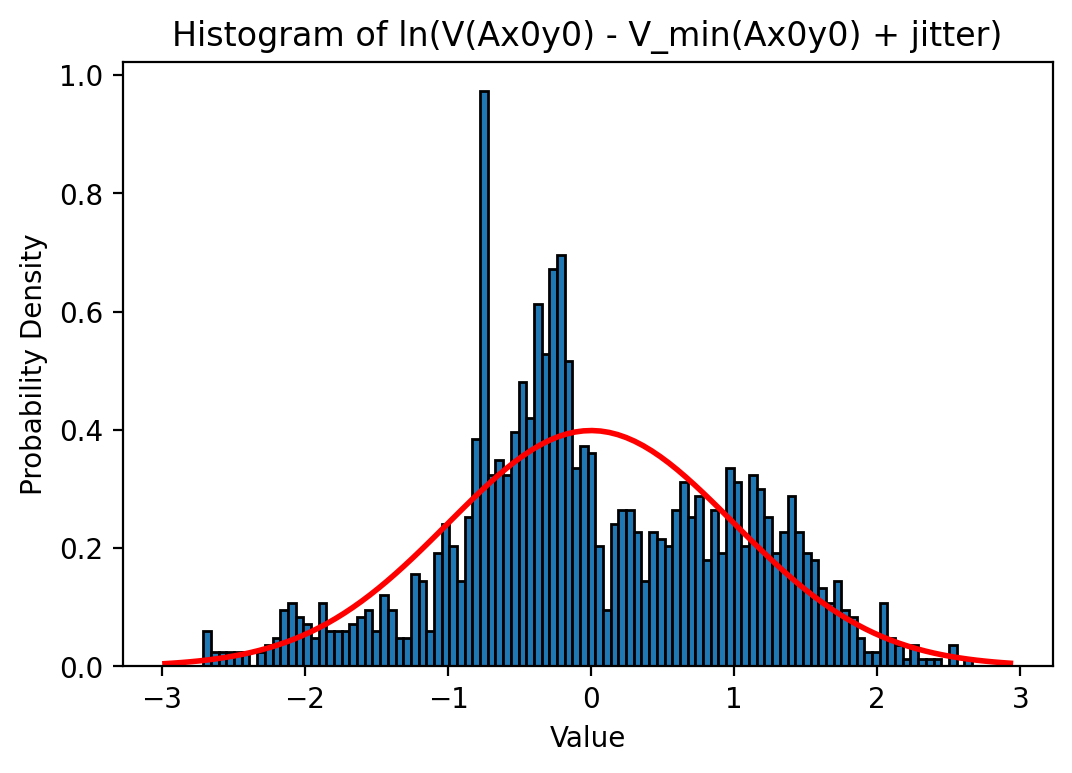

In [5]:

plt.hist(y, bins=100, density=True, edgecolor='black')  # Adjust the number of bins as needed
xmin, xmax = plt.xlim() 
mu, std = norm.fit(y[~np.isnan(y)])
print(mu, std)
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
plt.plot(x, p, 'r', linewidth=2) 


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram of ln(V(Ax0y0) - V_min(Ax0y0) + jitter)')

In [6]:
#Evaluate gp_mean over x values
#Generate validation data
val_data = simulator.gen_sim_data(10, 5, Gen_meth_enum(1), Gen_meth_enum(2), 1.0, simulator.seed, False)
feat_val = gp_object.featurize_data(val_data)
# gp_object.retrain_GP = 1

#Get gp mean
#Change hps of fit gp model or retrain GP
new_gp_model = gp_object.set_gp_model()
gp_object.train_gp(new_gp_model)
# gp_object.fit_gp_model.kernel_.k1.k2.length_scale = np.array([6.89, 6.89, 6.89, 6.89, 5.06, 1.86, 1.63])
# gp_object.fit_gp_model.kernel_.k2.noise_level = np.mean(y)*0.05
print(gp_object.fit_gp_model.kernel_)
misc_gp_mean, misc_var_return = gp_object.eval_gp_mean_var_misc(val_data, feat_val, covar = False)

In [ ]:
mse= np.sum((val_data.y_vals - misc_gp_mean)**2)/len(val_data.y_vals)
print("MSE:", mse)
plt.figure()
plt.scatter(val_data.y_vals, val_data.y_vals, color='red', alpha=0.7)
plt.scatter(val_data.y_vals, misc_gp_mean, color='blue', alpha=0.7)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot')
plt.grid(True)
plt.show()

In [ ]:
def max_min_distances(points):
    # Compute pairwise Euclidean distances between all points
    pairwise_distances = np.sqrt(np.sum((points[:, None] - points) ** 2, axis=-1))

    # Set the diagonal elements (self-distances) to infinity
    np.fill_diagonal(pairwise_distances, np.inf)
    # Mask out infinite values (self-distances)
    pairwise_distances = np.ma.masked_invalid(pairwise_distances)

    # Find the maximum and minimum distances
    max_distance = np.max(pairwise_distances)
    min_distance = np.min(pairwise_distances)

    return max_distance, min_distance

max, min = max_min_distances(gp_object.scalerX.transform(gp_object.feature_train_data))

In [ ]:
print(min, max)